In [ ]:
# Step 1: Load Data from Google Colab
from google.colab import drive
import pandas as pd

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
train = pd.read_csv('/content/drive/MyDrive/nlp-getting-started/train.csv')
test = pd.read_csv('/content/drive/MyDrive/nlp-getting-started/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/nlp-getting-started/sample_submission.csv')

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


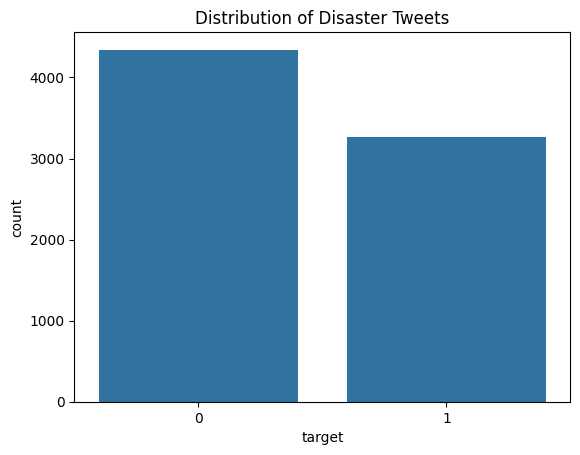

In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print(train.isnull().sum())

# Visualize the distribution of target labels
sns.countplot(x='target', data=train)
plt.title('Distribution of Disaster Tweets')
plt.show()

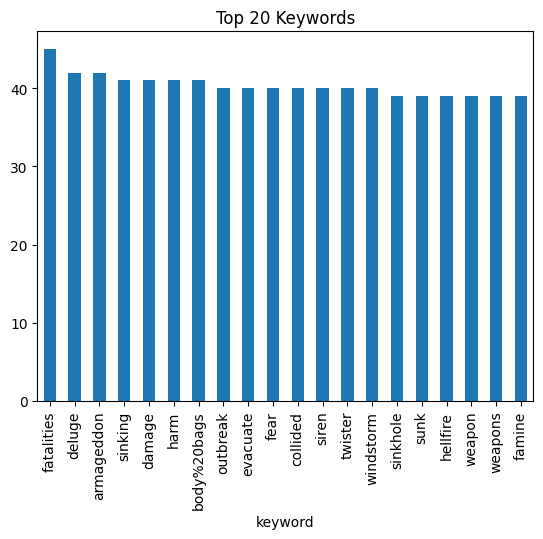

In [ ]:
# Visualize keyword frequency
train['keyword'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Keywords')
plt.show()

In [ ]:
# Step 3: Data Preprocessing
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preprocess the text (remove URLs, special characters, etc.)
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip
    return text

train['cleaned_text'] = train['text'].apply(preprocess_text)
test['cleaned_text'] = test['text'].apply(preprocess_text)

# Encode keyword and location (Handle missing values)
train['keyword'] = train['keyword'].fillna('none')
test['keyword'] = test['keyword'].fillna('none')

# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(train[['cleaned_text', 'keyword']], train['target'], test_size=0.2, random_state=42)


In [ ]:
print(train.columns)
print(test.columns)


Index(['id', 'keyword', 'location', 'text', 'target', 'cleaned_text'], dtype='object')
Index(['id', 'keyword', 'location', 'text', 'cleaned_text'], dtype='object')


#lstm

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Tokenization (keeping as is)
tokenizer = Tokenizer(num_words=3000, oov_token="<OOV>")
tokenizer.fit_on_texts(train["cleaned_text"])
train_sequences = tokenizer.texts_to_sequences(train["cleaned_text"])
train_padded = pad_sequences(train_sequences, padding='post')

test_sequences = tokenizer.texts_to_sequences(test["cleaned_text"])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=train_padded.shape[1])

train_labels = train["target"].values

# Define the model with changes
model = tf.keras.Sequential([

    # Embedding layer
    tf.keras.layers.Embedding(3000, 64, input_length=train_padded.shape[1]),

    # First Bidirectional LSTM layer with L2 regularization
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    tf.keras.layers.Dropout(0.3),  # Increased dropout

    # Second Bidirectional LSTM layer with L2 regularization
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    tf.keras.layers.Dropout(0.3),

    # Third Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Dense output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008), metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_padded, train_labels, epochs=20, validation_split=0.2, batch_size=32, callbacks=[early_stopping])


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6500 - loss: 3.3624 - val_accuracy: 0.7722 - val_loss: 0.5682
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8354 - loss: 0.4399 - val_accuracy: 0.7006 - val_loss: 0.5647
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8649 - loss: 0.3564 - val_accuracy: 0.7814 - val_loss: 0.4829
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8819 - loss: 0.3171 - val_accuracy: 0.7702 - val_loss: 0.5327
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8963 - loss: 0.2948 - val_accuracy: 0.7557 - val_loss: 0.5972
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9068 - loss: 0.2721 - val_accuracy: 0.7452 - val_loss: 0.6641


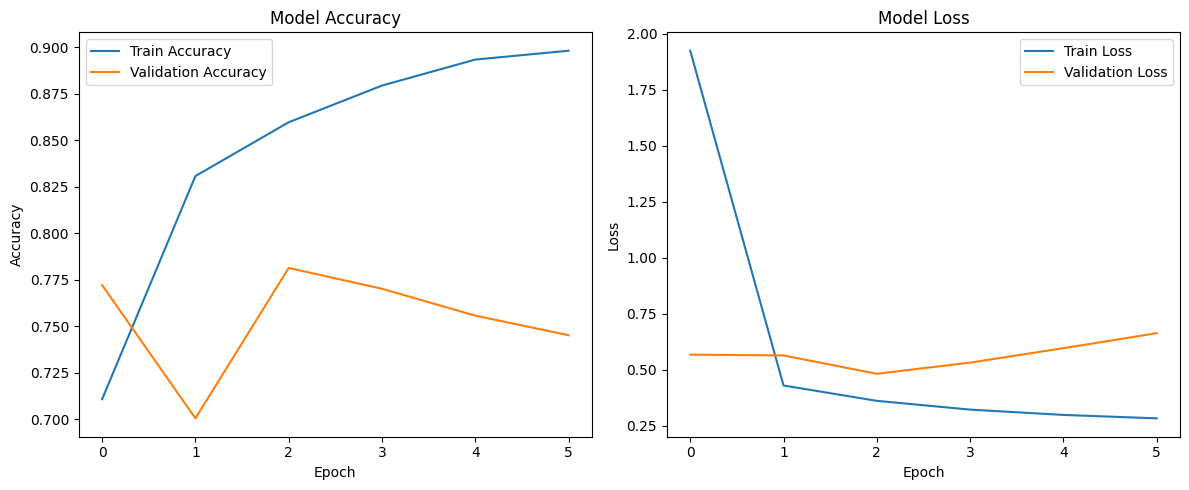

In [ ]:
import matplotlib.pyplot as plt

# Assuming you've trained your model with a call like this:
# history = model.fit(train_padded, train_labels, epochs=5, validation_split=0.2, batch_size=32)

# Plot accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming `test_padded` contains the test data and you have `train_labels`
# Make predictions on the validation or test data
predictions = model.predict(train_padded)  # Use validation or test data accordingly
predictions = np.round(predictions)  # Convert probabilities to 0 or 1

# Print the classification report
print(classification_report(train_labels, predictions, target_names=['Not Disaster', 'Disaster']))


238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
              precision    recall  f1-score   support

Not Disaster       0.83      0.96      0.89      4342
    Disaster       0.94      0.74      0.83      3271

    accuracy                           0.87      7613
   macro avg       0.88      0.85      0.86      7613
weighted avg       0.88      0.87      0.86      7613



238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


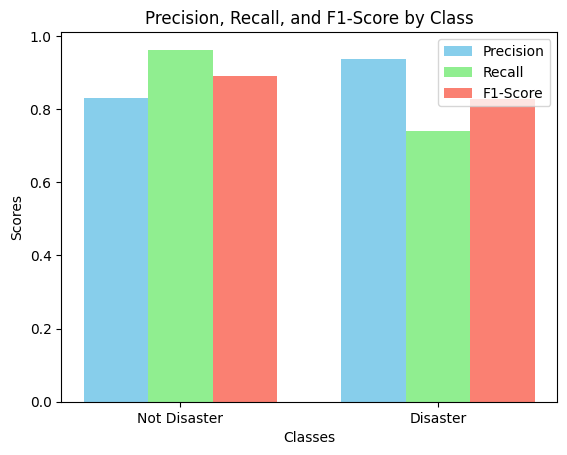

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

# Make predictions
predictions = model.predict(train_padded)
predictions = np.round(predictions)

# Generate the classification report as a dictionary
report = classification_report(train_labels, predictions, target_names=['Not Disaster', 'Disaster'], output_dict=True)

# Extract precision, recall, and f1-score for both classes
classes = ['Not Disaster', 'Disaster']
metrics = ['precision', 'recall', 'f1-score']

# Create a list of values to plot
precision_scores = [report[cls]['precision'] for cls in classes]
recall_scores = [report[cls]['recall'] for cls in classes]
f1_scores = [report[cls]['f1-score'] for cls in classes]

# Define the positions of the bars on the x-axis
x = np.arange(len(classes))

# Set the width of the bars
width = 0.25

# Plotting
fig, ax = plt.subplots()

# Plot bars for precision, recall, and f1-score
bars1 = ax.bar(x - width, precision_scores, width, label='Precision', color='skyblue')
bars2 = ax.bar(x, recall_scores, width, label='Recall', color='lightgreen')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='salmon')

# Add labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Display the plot
plt.show()
